### Image Model

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_folder = '/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database' 
# To make this work please go to the BMEN 415 shared folder and then select 'add shortcut to Drive'
# This will let the notebook access it through your instance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import keras

from keras import layers

# Rando stuff idk if we want to use
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling2D, Conv2D, Flatten, Dense, Rescaling

[PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-112.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-131.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-15.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-135.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-101.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-150.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-141.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-161.png'), PosixPath('/content/drive/MyDrive/BMEN415/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-113.png'), PosixPath('/content

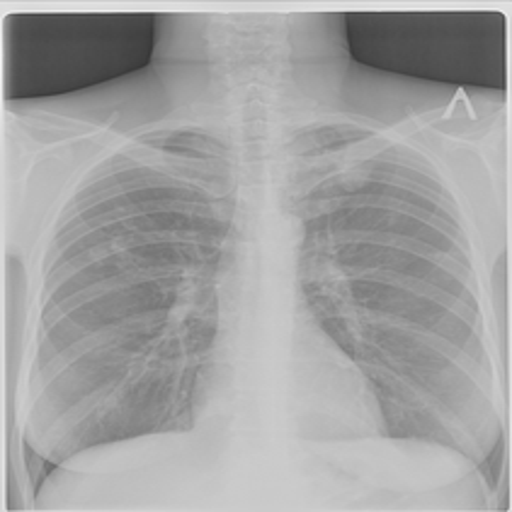

In [ ]:
import pathlib
path = pathlib.Path(root_folder)
imgs = list(path.glob('Tuberculosis/*'))
print(str(imgs))
PIL.Image.open(str(imgs[1]))

In [ ]:
im = PIL.Image.open(str(imgs[1]))

In [ ]:
# params we can use
img_width, img_height = im.size
n_channels = 3
batch_size = 1 # 32 is keras' default

input_shape = (img_height, img_width, n_channels)

# Defines training and validation datasets (full of pngs)
# This is the reccommended method
train_ds = tf.keras.utils.image_dataset_from_directory(
  root_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  root_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


In [ ]:
class_names = train_ds.class_names # Get the found class names

In [ ]:
# Here I'm letting Googlers handle performance tuning

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Do we need to normalize?

In [ ]:
num_classes = len(class_names)

# Build model architecture
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
        layers.Flatten()
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dropout (Dropout)           (None, 1016064)           0

In [ ]:
# Data augmentation?

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # idk what optimizer/loss to use - prob ADAM

In [ ]:
IMG_SIZE = img_height# Not Resized

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# train_ds = prepare(train_ds, shuffle=True, augment=True)

In [ ]:
epochs = 1

hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

3360/3360 [==============================] - ETA: 0s - loss: 7.6391 - accuracy: 0.8351